# Comment the following code and add widgets to adjust the number of terms in the approximations.

In [60]:
%matplotlib widget
from electrical_analysis.output.plot_tools import *
from electrical_analysis.waveform.tracemath import dB

import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import solve as linsolve


In [61]:
def ABCD_txline_approximation(Z, Y):
    Az = np.matrix([[1, Z], [0, 1]])
    Ay = np.matrix([[1, 0], [Y, 1]])
    Al = Az*Ay
    return Al

def solve_lc_approximation(f_v, Lpul, Cpul, l, N, Zs, Zl, Vs):
    jw_v = 1j*2*np.pi*np.array(f_v)
    
    V1 = np.zeros(f_v.shape, dtype=complex)
    I1 = np.zeros(f_v.shape, dtype=complex)
    V2 = np.zeros(f_v.shape, dtype=complex)
    I2 = np.zeros(f_v.shape, dtype=complex)
    
    dz_i = l/N
    for ii, jw_ in enumerate(jw_v):
        Z = jw_*Lpul*dz_i
        Y = jw_*Cpul*dz_i
        Atx_segment = ABCD_txline_approximation(Z,Y)
        Atx_total = Atx_segment**N
        
        Asys = np.matrix([[-1, 0, Atx_total[0,0], Atx_total[0,1]],
                          [0, -1, Atx_total[1,0], Atx_total[1,1]],
                          [1, Zs, 0, 0],
                          [0, 0, -1, Zl]])
        b = np.matrix([0, 0, Vs, 0]).transpose()
        x = linsolve(Asys, b)
        
        V1[ii] = x[0,0]
        I1[ii] = x[1,0]
        V2[ii] = x[2,0]
        I2[ii] = x[3,0]
    return V1, I1, V2, I2        

def solve_txline(f_v, Lpul, Cpul, l, Zs, Zl, Vs):
    Zo = np.sqrt(Lpul/Cpul)
    vp = 1./np.sqrt(Lpul*Cpul)
    
    jw_v = 1j*2*np.pi*np.array(f_v)
    jBeta_l = jw_v * l / vp
    
    Gamma = (Zl - Zo)/(Zl + Zo)
    Gamma_s = (Zs - Zo)/(Zs + Zo)
    
    Vplus = Vs*(Zo / (Zo + Zs)) * (np.e**(-jBeta_l) / (1 - Gamma_s*Gamma*np.e**(-2*jBeta_l)))
    
    V1 = Vplus * (np.e**(jBeta_l) + Gamma*np.e**(-jBeta_l))
    I1 = Vplus/Zo * (np.e**(jBeta_l) - Gamma*np.e**(-jBeta_l))
    V2 = Vplus * (1 + Gamma) 
    I2 = Vplus/Zo * (1 - Gamma)
    
    return V1, I1, V2, I2

# Need an ifft routine for step response.


In [62]:
Zo = 50.
co = 3e10 # cm/s
vp = co / np.sqrt(2.2) # cm/s
Zs = 50
Zl = 40
Vs = 1

Lpul = Zo/vp
Cpul = 1./(Zo*vp)

l = 5 # cm
N = 50

f_v = np.logspace(4, 10, 101)
f_v = np.linspace(1e4, 1e10, 10001)
V1, I1, V2, I2 = solve_lc_approximation(f_v, Lpul, Cpul, l, N, Zs, Zl, Vs)
V1t, I1t, V2t, I2t = solve_txline(f_v, Lpul, Cpul, l, Zs, Zl, Vs)

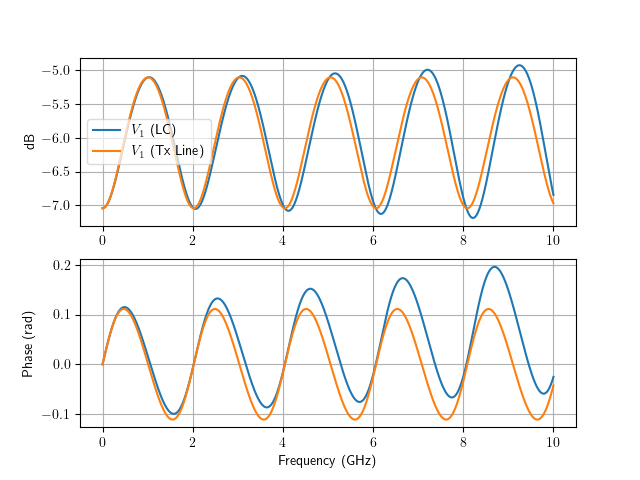

In [63]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
axp = fig.add_subplot(2,1,2, sharex=ax)

xfcn = lambda x_ : x_/1e9
yfcn = lambda y_ : dB(y_)

ax.plot(xfcn(f_v), yfcn(V1), label='$V_1$ (LC)')
ax.plot(xfcn(f_v), yfcn(V1t), label='$V_1$ (Tx Line)')

yfcn = lambda y_ : np.unwrap(np.angle(y_))
axp.plot(xfcn(f_v), yfcn(V1), label='$V_1$ (LC)')
axp.plot(xfcn(f_v), yfcn(V1t), label='$V_1$ (Tx Line)')

ax.grid(True)
axp.grid(True)
leg1 = ax.legend(loc='best')
legend_alpha(leg1, 0.7)
legend_linewidth(leg1, 1.5)

ax.set_ylabel('dB')
axp.set_ylabel('Phase (rad)')
axp.set_xlabel('Frequency (GHz)')

savefigure(fig, 'v1_%04d' % N, path='./figs')

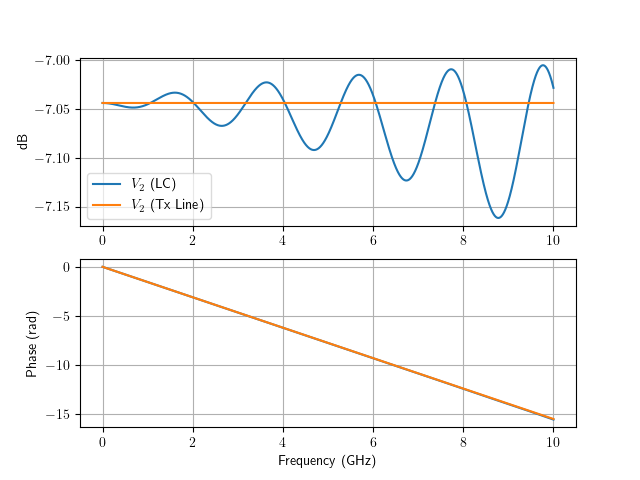

In [64]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
axp = fig.add_subplot(2,1,2, sharex=ax)

xfcn = lambda x_ : x_/1e9
yfcn = lambda y_ : dB(y_)

ax.plot(xfcn(f_v), yfcn(V2), label='$V_2$ (LC)')
ax.plot(xfcn(f_v), yfcn(V2t), label='$V_2$ (Tx Line)')

yfcn = lambda y_ : np.unwrap(np.angle(y_))
axp.plot(xfcn(f_v), yfcn(V2), label='$V_2$ (LC)')
axp.plot(xfcn(f_v), yfcn(V2t), label='$V_2$ (Tx Line)')

ax.grid(True)
axp.grid(True)
leg1 = ax.legend(loc='best')
legend_alpha(leg1, 0.7)
legend_linewidth(leg1, 1.5)

ax.set_ylabel('dB')
axp.set_ylabel('Phase (rad)')
axp.set_xlabel('Frequency (GHz)')

savefigure(fig, 'v2_%04d' % N, path='./figs')

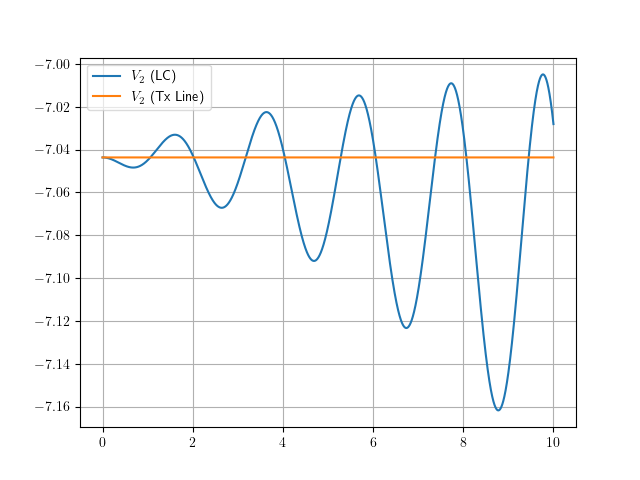

In [65]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

xfcn = lambda x_ : x_/1e9
yfcn = lambda y_ : dB(y_)

ax.plot(xfcn(f_v), yfcn(V2), label='$V_2$ (LC)')
ax.plot(xfcn(f_v), yfcn(V2t), label='$V_2$ (Tx Line)')
ax.grid(True)
leg1 = ax.legend(loc='best')
legend_alpha(leg1, 0.7)
legend_linewidth(leg1, 1.5)

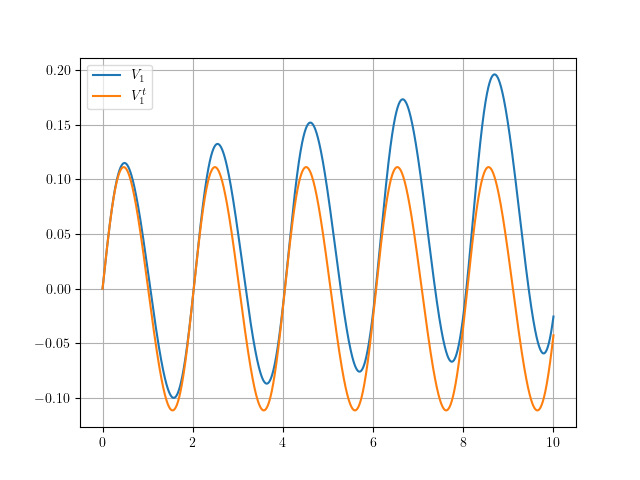

In [66]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

xfcn = lambda x_ : x_/1e9
yfcn = lambda y_ : np.unwrap(np.angle(y_))
#yfcn = lambda y_ : (np.angle(y_))

ax.plot(xfcn(f_v), yfcn(V1), label='$V_1$')
ax.plot(xfcn(f_v), yfcn(V1t), label='$V_1^t$')
ax.grid(True)
leg1 = ax.legend(loc='best')
legend_alpha(leg1, 0.7)
legend_linewidth(leg1, 1.5)

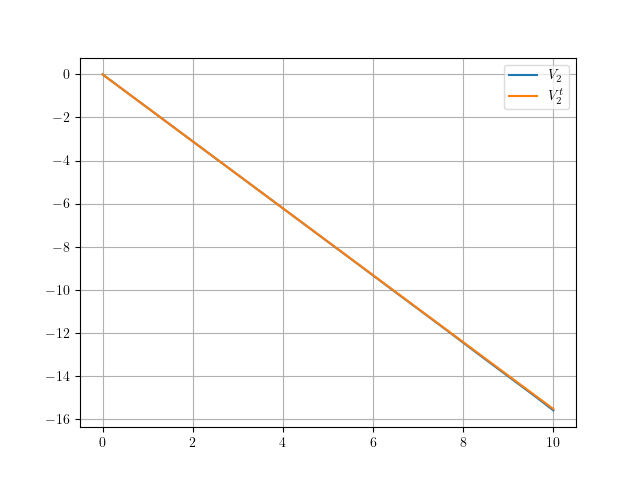

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

xfcn = lambda x_ : x_/1e9
yfcn = lambda y_ : np.unwrap(np.angle(y_))
#yfcn = lambda y_ : (np.angle(y_))

ax.plot(xfcn(f_v), yfcn(V2), label='$V_2$')
ax.plot(xfcn(f_v), yfcn(V2t), label='$V_2^t$')
ax.grid(True)
leg1 = ax.legend(loc='best')
legend_alpha(leg1, 0.7)
legend_linewidth(leg1, 1.5)